In [1]:
%matplotlib inline
import json
import embedding
import numpy as np
from keras import backend as K
from keras.utils.layer_utils import merge
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, Embedding, GRU
from keras.models import Model
import matplotlib.pyplot as plt

Using Theano backend.


In [2]:
def load(captions_filename, features_filename):
    features = np.load(features_filename)
    images = []
    texts = []
    with open(captions_filename) as fp:
        for line in fp:
            tokens = line.strip().split()
            images.append(tokens[0])
            texts.append(' '.join(tokens[1:]))
    return features, images, texts

In [3]:
features, images, texts = load('annotations.10k.txt', 'resnet50-features.10k.npy')
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
captions = pad_sequences(sequences, maxlen=16)
vocab = tokenizer.word_index
vocab['<eos>'] = 0  # add word with id 0

with open('vocab.json', 'w') as fp:  # save the vocab
    fp.write(json.dumps(vocab))

In [4]:
embedding_weights = embedding.load(vocab, 100, 'glove.twitter.27B.100d.filtered.txt')

loading embeddings from "glove.twitter.27B.100d.filtered.txt"


In [5]:
image_input = Input(shape=(2048,))
caption_input = Input(shape=(16,))
noise_input = Input(shape=(16,))

In [6]:
caption_embedding = Embedding(
    len(vocab), 100, input_length=16, weights=[embedding_weights])
caption_rnn = GRU(256)
image_dense = Dense(256, activation='tanh')

In [7]:
image_pipeline = image_dense(image_input)
caption_pipeline = caption_rnn(caption_embedding(caption_input))
noise_pipeline = caption_rnn(caption_embedding(noise_input))

In [8]:
positive_pair = merge([image_pipeline, caption_pipeline], mode='dot')
negative_pair = merge([image_pipeline, noise_pipeline], mode='dot')
output = merge([positive_pair, negative_pair], mode='concat')

In [9]:
training_model = Model(
    input=[image_input, caption_input, noise_input], output=output)
image_model = Model(input=image_input, output=image_pipeline)
caption_model = Model(input=caption_input, output=caption_pipeline)

In [10]:
def custom_loss(y_true, y_pred):
    positive = y_pred[:, 0]
    negative = y_pred[:, 1]
    return K.sum(K.maximum(0., 1. - positive + negative))


def accuracy(y_true, y_pred):
    positive = y_pred[:, 0]
    negative = y_pred[:, 1]
    return K.mean(positive > negative)

In [11]:
training_model.compile(loss=custom_loss, optimizer='adam', metrics=[accuracy])

In [12]:
noise = np.copy(captions)
fake_labels = np.zeros((len(features), 1))
X_train = [features[:9000], captions[:9000], noise[:9000]]
Y_train = fake_labels[:9000]
X_valid = [features[-1000:], captions[-1000:], noise[-1000:]]
Y_valid = fake_labels[-1000:]

In [13]:
training_accuracy = []
testing_accuracy = []
training_loss = []
testing_loss = []

for epoch in range(11):
    np.random.shuffle(noise)  # don’t forget to shuffle mismatched captions
    history = training_model.fit(X_train, Y_train,
                                 validation_data=[
                                     X_valid, Y_valid], nb_epoch=1,
                                 batch_size=64)
    training_accuracy.append(history.history['accuracy'])
    testing_accuracy.append(history.history['val_accuracy'])
    training_loss.append(history.history['loss'])
    testing_loss.append(history.history['val_loss'])

Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 56s - loss: 38.8268 - accuracy: 0.8161 - val_loss: 19.6186 - val_accuracy: 0.8950
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 58s - loss: 15.8411 - accuracy: 0.9104 - val_loss: 19.4530 - val_accuracy: 0.8860
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 66s - loss: 13.1476 - accuracy: 0.9232 - val_loss: 13.4561 - val_accuracy: 0.9170
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 57s - loss: 11.8671 - accuracy: 0.9310 - val_loss: 15.9337 - val_accuracy: 0.9100
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [==============================] - 60s - loss: 9.9772 - accuracy: 0.9418 - val_loss: 12.1490 - val_accuracy: 0.9320
Train on 9000 samples, validate on 1000 samples
Epoch 1/1
9000/9000 [=======

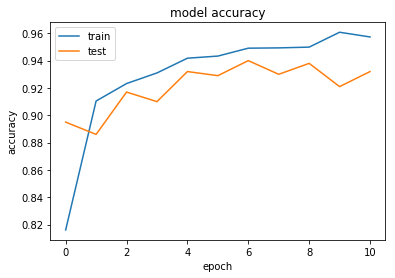

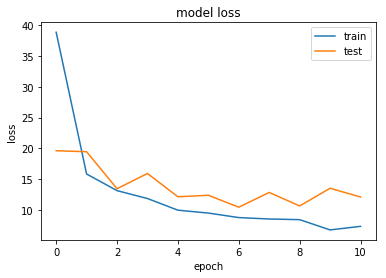

In [14]:
# summarize history for accuracy
plt.plot(training_accuracy)
plt.plot(testing_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(training_loss)
plt.plot(testing_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [15]:
# save models
image_model.save('model.11epoch.image')
caption_model.save('model.11epoch.caption')

In [16]:
# save representations
np.save('caption-representations-11epoch', caption_model.predict(captions))
np.save('image-representations-11epoch', image_model.predict(features))